In [1]:
import torch, torchaudio, torchvision.transforms as transforms, matplotlib.pyplot as plt, torch.nn as nn, torch.optim as optim, numpy as np
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, classification_report, roc_auc_score
from torch.autograd import grad


cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")

data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]


NVIDIA A30
(872, 4500, 14) (872,)


# Vanilla GAN

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Vanilla GAN Generator
class VanillaGANGenerator(nn.Module):
    def __init__(self, latent_dim=100, n_features=14, seq_len=4500):
        super(VanillaGANGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.n_features = n_features
        self.seq_len = seq_len
        
        # Calculate reasonable initial size
        self.init_size = max(seq_len // 64, 32)
        
        # Initial projection
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_size),
            nn.BatchNorm1d(128 * self.init_size),
            nn.ReLU(inplace=True)
        )
        
        # Upsampling blocks
        self.conv_blocks = nn.Sequential(
            # 128 -> 64 channels
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            
            # 64 -> 32 channels
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            
            # 32 -> 16 channels
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            
            # 16 -> n_features channels
            nn.ConvTranspose1d(16, n_features, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output in [-1, 1]
        )
        
    def forward(self, z):
        # Project latent to initial conv size
        out = self.fc(z)
        out = out.view(out.shape[0], 128, self.init_size)
        
        # Progressive upsampling
        out = self.conv_blocks(out)
        
        # Ensure exact sequence length
        if out.shape[2] != self.seq_len:
            out = nn.functional.interpolate(out, size=self.seq_len, mode='linear', align_corners=False)
        
        # Return as (batch_size, seq_len, n_features)
        return out.transpose(1, 2)

# Vanilla GAN Discriminator
class VanillaGANDiscriminator(nn.Module):
    def __init__(self, n_features=14, seq_len=4500):
        super(VanillaGANDiscriminator, self).__init__()
        
        # Downsampling blocks
        self.conv_blocks = nn.Sequential(
            # n_features -> 16 channels
            nn.Conv1d(n_features, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # 16 -> 32 channels
            nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # 32 -> 64 channels
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # 64 -> 128 channels
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Calculate output size after convolutions
        self.conv_output_size = self._get_conv_output_size(seq_len)
        
        # Binary classifier
        self.classifier = nn.Sequential(
            nn.Linear(128 * self.conv_output_size, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Output probability [0, 1]
        )
        
    def _get_conv_output_size(self, seq_len):
        size = seq_len
        for _ in range(4):  # 4 conv layers
            size = (size - 4 + 2) // 2 + 1
        return size
    
    def forward(self, x):
        # Input: (batch_size, seq_len, n_features)
        x = x.transpose(1, 2)  # Convert to (batch_size, n_features, seq_len)
        
        # Apply conv blocks
        features = self.conv_blocks(x)
        
        # Flatten and classify
        features = features.view(features.size(0), -1)
        output = self.classifier(features)
        
        return output

# Vanilla GAN training function
def train_vanilla_gan(normal_data, device, n_epochs=50, batch_size=32, lr_g=2e-4, lr_d=2e-4):
    """
    Train Vanilla GAN with binary cross-entropy loss
    """
    print(f"Starting Vanilla GAN Training")
    print(f"Data shape: {normal_data.shape}")
    print(f"Raw data range: [{normal_data.min():.4f}, {normal_data.max():.4f}]")
    
    # Data preprocessing - scale to [-1, 1] for tanh output
    data_mean = np.mean(normal_data, axis=(0, 1), keepdims=True)
    data_std = np.std(normal_data, axis=(0, 1), keepdims=True) + 1e-8
    
    # Normalize to [-1, 1]
    normalized_data = (normal_data - data_mean) / data_std
    normalized_data = np.tanh(normalized_data)  # Ensure [-1, 1] range
    
    print(f"Normalized data range: [{normalized_data.min():.4f}, {normalized_data.max():.4f}]")
    
    # Model parameters
    latent_dim = 100
    n_features = normalized_data.shape[-1]
    seq_len = normalized_data.shape[1]
    
    # Initialize models
    generator = VanillaGANGenerator(latent_dim, n_features, seq_len).to(device)
    discriminator = VanillaGANDiscriminator(n_features, seq_len).to(device)
    
    # Weight initialization
    def init_weights(m):
        if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d, nn.Linear)):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)
    
    generator.apply(init_weights)
    discriminator.apply(init_weights)
    
    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    
    # Loss function
    criterion = nn.BCELoss()
    
    # Create dataloader
    dataset = TensorDataset(torch.tensor(normalized_data, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    print(f"Training Parameters:")
    print(f"  Epochs: {n_epochs}, Batch Size: {batch_size}")
    print(f"  Generator LR: {lr_g}, Discriminator LR: {lr_d}")
    
    # Training history
    d_losses = []
    g_losses = []
    d_accuracies = []
    
    print("\nStarting Training...")
    print("=" * 60)
    
    for epoch in range(n_epochs):
        epoch_d_losses = []
        epoch_g_losses = []
        epoch_d_accuracies = []
        
        for i, (real_samples,) in enumerate(dataloader):
            real_samples = real_samples.to(device)
            batch_size_actual = real_samples.size(0)
            
            # Real and fake labels
            real_labels = torch.ones(batch_size_actual, 1, device=device)
            fake_labels = torch.zeros(batch_size_actual, 1, device=device)
            
            # ========================
            # Train Discriminator
            # ========================
            optimizer_D.zero_grad()
            
            # Real samples
            real_output = discriminator(real_samples)
            d_loss_real = criterion(real_output, real_labels)
            
            # Generate fake samples
            z = torch.randn(batch_size_actual, latent_dim, device=device)
            fake_samples = generator(z).detach()
            fake_output = discriminator(fake_samples)
            d_loss_fake = criterion(fake_output, fake_labels)
            
            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()
            
            # Calculate discriminator accuracy
            real_pred = (real_output > 0.5).float()
            fake_pred = (fake_output > 0.5).float()
            d_accuracy = ((real_pred == real_labels).sum() + (fake_pred == fake_labels).sum()).float() / (2 * batch_size_actual)
            
            epoch_d_losses.append(d_loss.item())
            epoch_d_accuracies.append(d_accuracy.item())
            
            # ========================
            # Train Generator
            # ========================
            optimizer_G.zero_grad()
            
            # Generate fake samples
            z = torch.randn(batch_size_actual, latent_dim, device=device)
            fake_samples = generator(z)
            fake_output = discriminator(fake_samples)
            
            # Generator loss (wants discriminator to classify fakes as real)
            g_loss = criterion(fake_output, real_labels)
            
            g_loss.backward()
            optimizer_G.step()
            
            epoch_g_losses.append(g_loss.item())
        
        # Calculate epoch averages
        avg_d_loss = np.mean(epoch_d_losses)
        avg_g_loss = np.mean(epoch_g_losses)
        avg_d_accuracy = np.mean(epoch_d_accuracies)
        
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)
        d_accuracies.append(avg_d_accuracy)
        
        # Print progress
        if epoch % 5 == 0 or epoch == n_epochs - 1:
            print(f"Epoch [{epoch+1:3d}/{n_epochs}] | "
                  f"D Loss: {avg_d_loss:8.4f} | "
                  f"G Loss: {avg_g_loss:8.4f} | "
                  f"D Acc: {avg_d_accuracy:6.3f}")
            
            # Check for mode collapse or training issues
            if avg_d_accuracy < 0.1 or avg_d_accuracy > 0.9:
                print("         ⚠️  Potential training instability detected")
            elif 0.4 <= avg_d_accuracy <= 0.6:
                print("         ✅ Training appears balanced")
    
    print("=" * 60)
    print("Training completed!")
    
    # Store normalization parameters for generation
    data_stats = (data_mean, data_std)
    
    return generator, discriminator, d_losses, g_losses, d_accuracies, data_stats

# Sample generation for Vanilla GAN
def generate_vanilla_samples(generator, num_samples, latent_dim, device, data_stats, batch_size=32):
    """
    Generate samples and denormalize them
    """
    generator.eval()
    data_mean, data_std = data_stats
    
    generated_batches = []
    
    with torch.no_grad():
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            current_batch_size = end - start
            
            # Generate noise
            z = torch.randn(current_batch_size, latent_dim, device=device)
            
            # Generate samples
            batch_generated = generator(z)
            
            # Denormalize from [-1, 1] back to original scale
            batch_generated = batch_generated.cpu().numpy()
            batch_generated = np.arctanh(np.clip(batch_generated, -0.99, 0.99))  # Inverse tanh
            batch_generated = batch_generated * data_std + data_mean
            
            generated_batches.append(batch_generated)
    
    return np.concatenate(generated_batches, axis=0)

# Visualization for Vanilla GAN
def plot_vanilla_training_curves(d_losses, g_losses, d_accuracies):
    """
    Plot training curves for Vanilla GAN
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Discriminator loss
    axes[0].plot(d_losses, label='Discriminator Loss', color='blue', alpha=0.7)
    axes[0].set_title('Discriminator Loss Over Time')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Generator loss
    axes[1].plot(g_losses, label='Generator Loss', color='red', alpha=0.7)
    axes[1].set_title('Generator Loss Over Time')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Discriminator accuracy
    axes[2].plot(d_accuracies, label='Discriminator Accuracy', color='green', alpha=0.7)
    axes[2].axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Random Guess')
    axes[2].set_title('Discriminator Accuracy Over Time')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy')
    axes[2].set_ylim(0, 1)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# GANs Training

Training Vanilla GAN...
Starting Vanilla GAN Training
Data shape: (690, 4500, 14)
Raw data range: [-3995.8000, 127440.0000]
Normalized data range: [-1.0000, 1.0000]
Training Parameters:
  Epochs: 60, Batch Size: 32
  Generator LR: 0.002, Discriminator LR: 1e-05

Starting Training...
Epoch [  1/60] | D Loss:   1.6503 | G Loss:   0.5706 | D Acc:  0.315
Epoch [  6/60] | D Loss:   1.3438 | G Loss:   0.6003 | D Acc:  0.589
         ✅ Training appears balanced
Epoch [ 11/60] | D Loss:   1.4222 | G Loss:   0.6469 | D Acc:  0.492
         ✅ Training appears balanced
Epoch [ 16/60] | D Loss:   1.5587 | G Loss:   0.5660 | D Acc:  0.333
Epoch [ 21/60] | D Loss:   1.5196 | G Loss:   0.6097 | D Acc:  0.312
Epoch [ 26/60] | D Loss:   1.4591 | G Loss:   0.6539 | D Acc:  0.397
Epoch [ 31/60] | D Loss:   1.4283 | G Loss:   0.6571 | D Acc:  0.446
         ✅ Training appears balanced
Epoch [ 36/60] | D Loss:   1.3932 | G Loss:   0.7096 | D Acc:  0.498
         ✅ Training appears balanced
Epoch [ 41/60] |

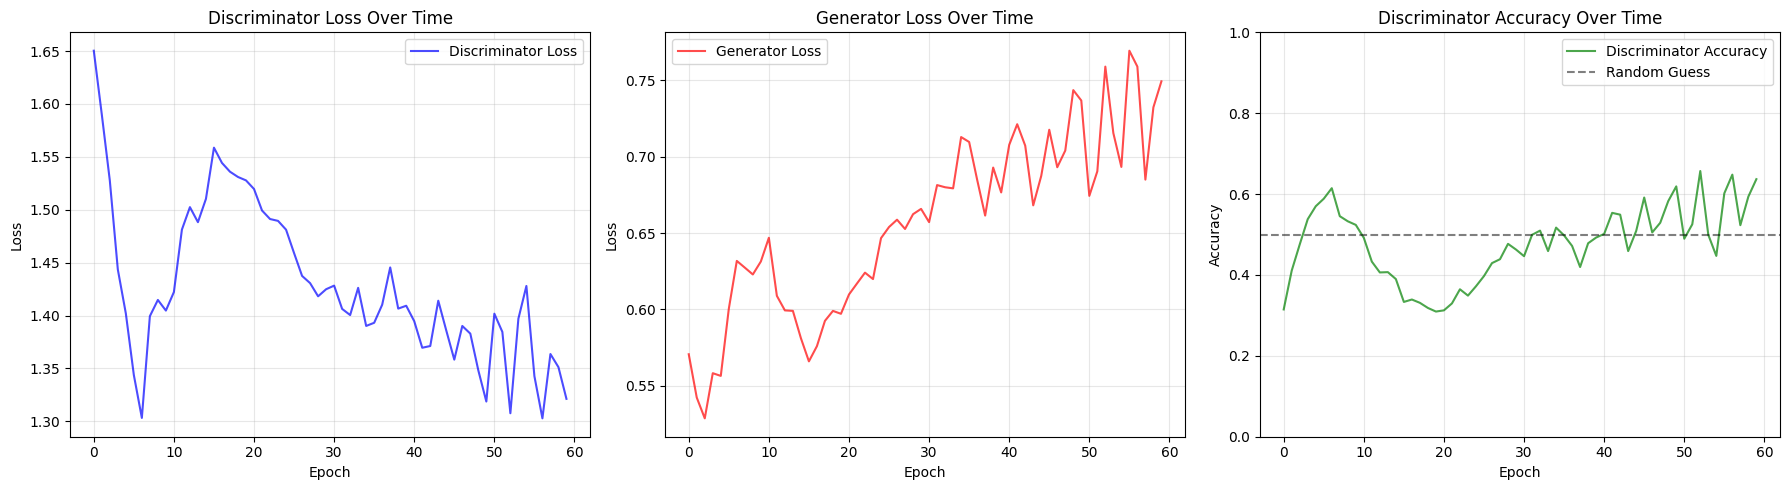

In [8]:
# Train the ultra-stable WGAN
print("Training Vanilla GAN...")
generator, discriminator, d_history, g_history, d_acc_history, data_stats = train_vanilla_gan(
    normal_data,
    device,
    n_epochs=60,
    batch_size=32,
    lr_g=0.002,
    lr_d=0.00001
)

# Plot training curves
plot_vanilla_training_curves(d_history, g_history, d_acc_history)



# Generate and Combine

In [9]:

# Generate samples
print("Generating synthetic samples...")
generated_data = generate_vanilla_samples(
    generator,
    len(normal_data),
    latent_dim=100,
    device=device,
    data_stats=data_stats,
    batch_size=32
)

print(f"Generated data shape: {generated_data.shape}")
print(f"Generated data range: [{generated_data.min():.4f}, {generated_data.max():.4f}]")
print(f"Original data range: [{normal_data.min():.4f}, {normal_data.max():.4f}]")

# Combine with real data
combine_data_normal = np.concatenate((generated_data, normal_data), axis=0)
combine_labels_normal = np.concatenate((np.zeros(len(generated_data)), normal_label), axis=0)

print("✅ Ultra-stable WGAN training completed!")

Generating synthetic samples...
Generated data shape: (690, 4500, 14)
Generated data range: [-47722.9062, 217590.2188]
Original data range: [-3995.8000, 127440.0000]
✅ Ultra-stable WGAN training completed!


# Processing: Mel Spec > Resizing > Feature Extraction

In [10]:
def resize_spectrogram(spectrogram, global_min=None, global_max=None):
    """
    Improved spectrogram processing with consistent normalization
    """
    # Use global min/max for consistent normalization across all spectrograms
    if global_min is not None and global_max is not None:
        spectrogram = (spectrogram - global_min) / (global_max - global_min + 1e-8)
    else:
        spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-8)
    
    # Clip to [0,1] and convert to uint8
    spectrogram = np.clip(spectrogram, 0, 1)
    spectrogram = np.uint8(spectrogram.cpu().numpy() * 255)
    spectrogram = np.stack([spectrogram] * 3, axis=-1)
    
    image = Image.fromarray(spectrogram)
    image = transforms.Resize((224, 224))(image)
    return transforms.ToTensor()(image)

def process_dataset_improved(data, sample_rate=1000):  # More reasonable sample rate
    """
    Improved dataset processing with better mel-spectrogram parameters
    """
    num_samples, seq_len, num_channels = data.shape
    features = np.zeros((num_samples, num_channels, 4096))
    
    # Better mel-spectrogram parameters for sensor data
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=512,          # Reasonable FFT size
        hop_length=256,     # 50% overlap
        win_length=512,
        window_fn=torch.hann_window
    ).to(device)
    
    # Load VGG16 model
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()
    
    # Compute global min/max for consistent normalization
    print("Computing global spectrogram statistics...")
    all_mels = []
    for i in range(min(100, num_samples)):  # Sample subset for statistics
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            all_mels.append(mel.cpu().numpy())
    
    all_mels = np.concatenate([mel.flatten() for mel in all_mels])
    global_min, global_max = np.percentile(all_mels, [1, 99])  # Use percentiles to avoid outliers
    
    print(f"Processing {num_samples} samples...")
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples")
            
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            
            # Use consistent normalization
            img = resize_spectrogram(mel, global_min, global_max)
            
            with torch.no_grad():
                feat = model(img.unsqueeze(0).to(device))
            features[i, j, :] = feat.squeeze().cpu().numpy()
    
    return features

# Alternative: Multi-channel processing
def process_dataset_multichannel(data, sample_rate=1000):
    """
    Process multiple channels together to capture cross-channel relationships
    """
    num_samples, seq_len, num_channels = data.shape
    features = np.zeros((num_samples, 4096))  # Single feature vector per sample
    
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=512,
        hop_length=256,
        win_length=512
    ).to(device)
    
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()
    
    print(f"Processing {num_samples} samples with multi-channel approach...")
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples")
        
        # Combine multiple channels into RGB image
        channel_spectrograms = []
        for j in range(min(3, num_channels)):  # Use first 3 channels as RGB
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            
            # Normalize each channel spectrogram
            mel_norm = (mel - mel.min()) / (mel.max() - mel.min() + 1e-8)
            mel_resized = torch.nn.functional.interpolate(
                mel_norm.unsqueeze(0).unsqueeze(0), 
                size=(224, 224), 
                mode='bilinear'
            ).squeeze()
            channel_spectrograms.append(mel_resized.cpu().numpy())
        
        # Stack as RGB image
        if len(channel_spectrograms) == 1:
            rgb_img = np.stack([channel_spectrograms[0]] * 3, axis=0)
        elif len(channel_spectrograms) == 2:
            rgb_img = np.stack([channel_spectrograms[0], channel_spectrograms[1], channel_spectrograms[0]], axis=0)
        else:
            rgb_img = np.stack(channel_spectrograms[:3], axis=0)
        
        img_tensor = torch.tensor(rgb_img, dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            feat = model(img_tensor)
        features[i, :] = feat.squeeze().cpu().numpy()
    
    return features

# AE Class

In [11]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size=4096):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64), 
            nn.Tanh(),
            nn.Linear(64, 32), 
            nn.Tanh(),
            nn.Linear(32, 16), 
            nn.Tanh(),
            nn.Linear(16, 8), 
            nn.Tanh(),
            nn.Linear(8, 4), 
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.Tanh(),
            nn.Linear(8, 16), 
            nn.Tanh(),
            nn.Linear(16, 32), 
            nn.Tanh(),
            nn.Linear(32, 64), 
            nn.Tanh(),
            nn.Linear(64, input_size), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


# Train autoencoder
def train_autoencoder(features, epochs=20, batch_size=128):
    x = torch.tensor(features.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(x), batch_size=batch_size, shuffle=True)
    model = Autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Add weight decay
    criterion = nn.MSELoss()  # Try MSE instead of L1

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            inputs = batch[0]
            # Add noise for denoising autoencoder
            noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
            outputs = model(noisy_inputs)
            loss = criterion(outputs, inputs)  # Reconstruct clean from noisy
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.6f}")
    return model

# Compute reconstruction errors
def compute_reconstruction_loss(model, data, add_noise=True):
    """
    Compute reconstruction loss per sample (not per segment)
    data: shape (n_samples, n_channels, 4096)
    """
    model.eval()
    n_samples, n_channels, n_features = data.shape
    sample_errors = []
    
    # Flatten to (n_samples*n_channels, 4096) for batch processing
    x = torch.tensor(data.reshape(-1, n_features), dtype=torch.float32).to(next(model.parameters()).device)
    loader = DataLoader(TensorDataset(x), batch_size=64)
    
    all_errors = []
    criterion = torch.nn.MSELoss(reduction='none')
    
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            
            if add_noise:
                noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
                outputs = model(noisy_inputs)
            else:
                outputs = model(inputs)
            
            # Per-segment reconstruction error
            segment_errors = criterion(outputs, inputs).mean(dim=1)
            all_errors.extend(segment_errors.cpu().numpy())
    
    # Reshape back to (n_samples, n_channels) and aggregate per sample
    all_errors = np.array(all_errors).reshape(n_samples, n_channels)
    sample_errors = all_errors.mean(axis=1)  # Average across channels per sample
    
    return sample_errors

# 2. Find best threshold based on F1 score
def find_best_threshold(errors, labels):
    best_f1 = 0
    best_threshold = 0
    for threshold in np.linspace(min(errors), max(errors), 100):
        preds = (errors > threshold).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

def evaluate_on_test_with_threshold_search(model, X_test, y_test):
    """
    X_test: shape (n_samples, 1, 4096) - already has channel dimension added
    y_test: shape (n_samples,)
    """
    # X_test already has shape (n_samples, 1, 4096) from your code
    # So we can directly compute reconstruction errors
    test_errors = compute_reconstruction_loss(model, X_test)
    
    # Find best threshold based on F1 score
    best_threshold = 0
    best_f1 = 0
    for threshold in np.linspace(test_errors.min(), test_errors.max(), 100):
        preds = (test_errors > threshold).astype(int)
        f1 = f1_score(y_test, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Predict using best threshold
    test_preds = (test_errors > best_threshold).astype(int)

    # Evaluate
    print(f"Best Threshold = {best_threshold:.6f}, Best F1 Score = {best_f1:.4f}")
    print("Evaluation on Test Set:")
    print("Accuracy =", accuracy_score(y_test, test_preds))
    print("Precision =", precision_score(y_test, test_preds))
    print("Recall =", recall_score(y_test, test_preds))
    print("F1 Score =", f1_score(y_test, test_preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))


# Preprocessing

In [12]:
combine_data = np.concatenate((combine_data_normal, data[label == 1]), axis=0)  # Combine real and generated data
combine_label = np.concatenate((np.zeros(len(combine_labels_normal)), label[label == 1]), axis=0)  # Labels: 0 for real, 0 for generated

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaled_normal_data = StandardScaler().fit_transform(combine_data_normal.reshape(-1, combine_data_normal.shape[-1])).reshape(combine_data_normal.shape)
scaled_original_data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
features_original = process_dataset_multichannel(scaled_original_data)
print("Features shape:", features_original.shape)
features_normal = process_dataset_multichannel(scaled_normal_data)
print("Features shape:", features_normal.shape)

Processing 872 samples with multi-channel approach...
Processed 0/872 samples
Processed 100/872 samples
Processed 200/872 samples
Processed 300/872 samples
Processed 400/872 samples
Processed 500/872 samples
Processed 600/872 samples
Processed 700/872 samples
Processed 800/872 samples
Features shape: (872, 4096)
Processing 1380 samples with multi-channel approach...
Processed 0/1380 samples
Processed 100/1380 samples
Processed 200/1380 samples
Processed 300/1380 samples
Processed 400/1380 samples
Processed 500/1380 samples
Processed 600/1380 samples
Processed 700/1380 samples
Processed 800/1380 samples
Processed 900/1380 samples
Processed 1000/1380 samples
Processed 1100/1380 samples
Processed 1200/1380 samples
Processed 1300/1380 samples
Features shape: (1380, 4096)


# Cross Validation with StandardScaler

Fold 1
Epoch 1/15, Loss: 1.132967
Epoch 2/15, Loss: 0.789221
Epoch 3/15, Loss: 0.561695
Epoch 4/15, Loss: 0.529548
Epoch 5/15, Loss: 0.524849
Epoch 6/15, Loss: 0.523843
Epoch 7/15, Loss: 0.523086
Epoch 8/15, Loss: 0.522489
Epoch 9/15, Loss: 0.522020
Epoch 10/15, Loss: 0.521786
Epoch 11/15, Loss: 0.521609
Epoch 12/15, Loss: 0.521181
Epoch 13/15, Loss: 0.521228
Epoch 14/15, Loss: 0.520965
Epoch 15/15, Loss: 0.520750
Best threshold: 0.5077704549437821, Best F1 Score: 0.47058823529411764


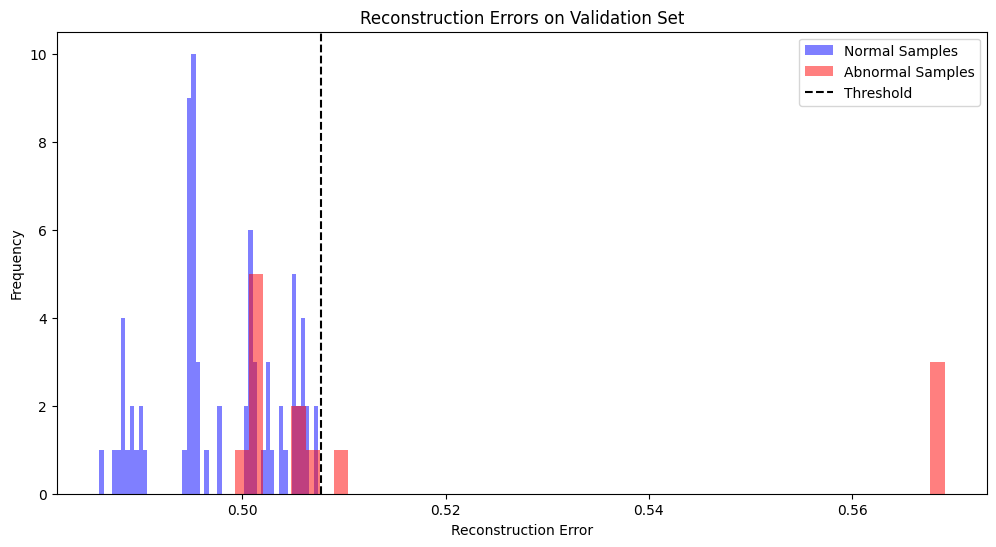

Best Threshold = 0.504839, Best F1 Score = 0.7037
Evaluation on Test Set:
Accuracy = 0.8181818181818182
Precision = 0.6333333333333333
Recall = 0.7916666666666666
F1 Score = 0.7037037037037038
Confusion Matrix:
 [[53 11]
 [ 5 19]]
Fold 2
Epoch 1/15, Loss: 1.142469
Epoch 2/15, Loss: 0.809758
Epoch 3/15, Loss: 0.562706
Epoch 4/15, Loss: 0.528990
Epoch 5/15, Loss: 0.524784
Epoch 6/15, Loss: 0.523595
Epoch 7/15, Loss: 0.523267
Epoch 8/15, Loss: 0.522616
Epoch 9/15, Loss: 0.522071
Epoch 10/15, Loss: 0.521979
Epoch 11/15, Loss: 0.521455
Epoch 12/15, Loss: 0.521234
Epoch 13/15, Loss: 0.520895
Epoch 14/15, Loss: 0.521170
Epoch 15/15, Loss: 0.520757
Best threshold: 0.5059211856186991, Best F1 Score: 0.8484848484848485


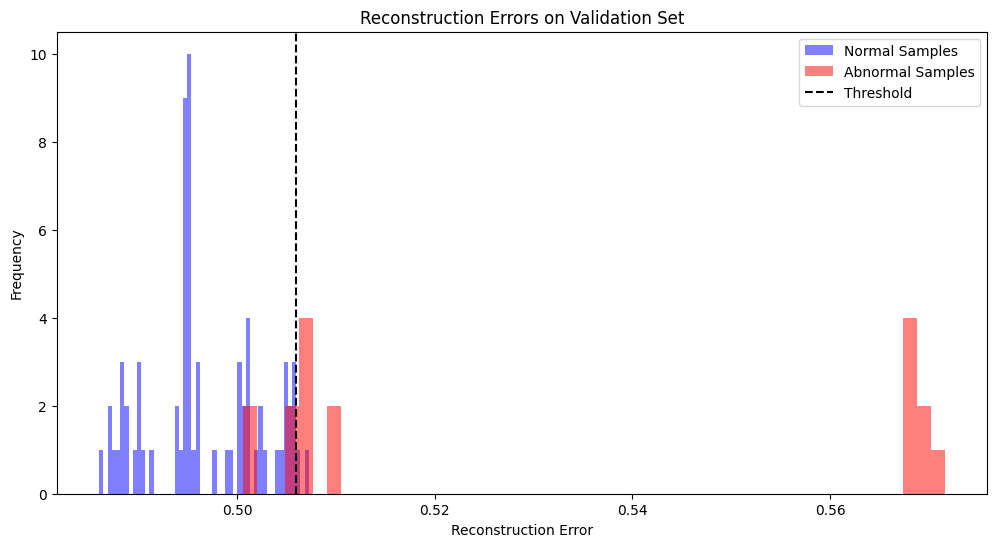

Best Threshold = 0.505089, Best F1 Score = 0.6364
Evaluation on Test Set:
Accuracy = 0.8181818181818182
Precision = 0.5833333333333334
Recall = 0.7
F1 Score = 0.6363636363636365
Confusion Matrix:
 [[58 10]
 [ 6 14]]
Fold 3
Epoch 1/15, Loss: 1.121242
Epoch 2/15, Loss: 0.767923
Epoch 3/15, Loss: 0.559668
Epoch 4/15, Loss: 0.530335
Epoch 5/15, Loss: 0.525808
Epoch 6/15, Loss: 0.524505
Epoch 7/15, Loss: 0.523413
Epoch 8/15, Loss: 0.522777
Epoch 9/15, Loss: 0.522318
Epoch 10/15, Loss: 0.521905
Epoch 11/15, Loss: 0.521721
Epoch 12/15, Loss: 0.521389
Epoch 13/15, Loss: 0.521087
Epoch 14/15, Loss: 0.520976
Epoch 15/15, Loss: 0.520838
Best threshold: 0.5010508786548268, Best F1 Score: 0.6071428571428571


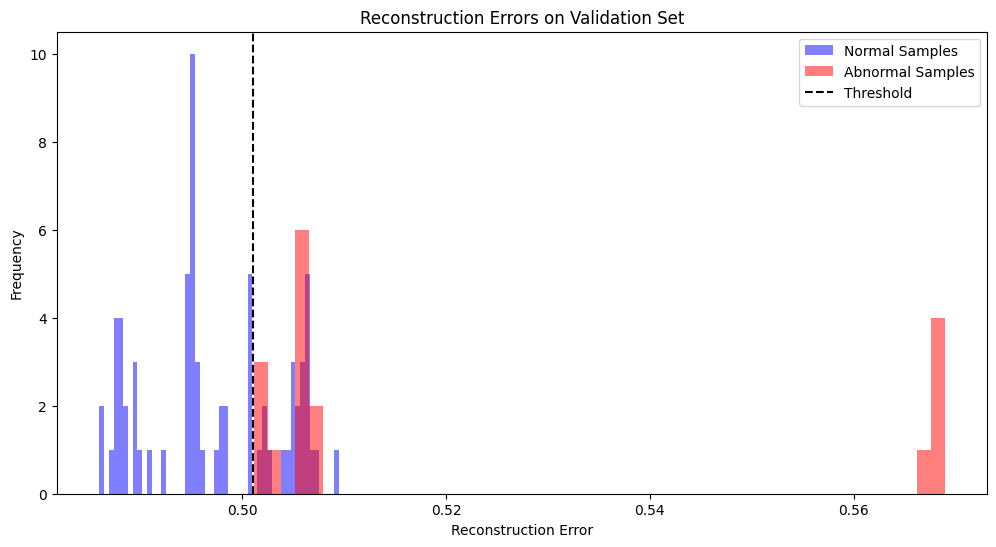

Best Threshold = 0.502105, Best F1 Score = 0.6038
Evaluation on Test Set:
Accuracy = 0.7586206896551724
Precision = 0.47058823529411764
Recall = 0.8421052631578947
F1 Score = 0.6037735849056604
Confusion Matrix:
 [[50 18]
 [ 3 16]]
Fold 4
Epoch 1/15, Loss: 1.135584
Epoch 2/15, Loss: 0.777800
Epoch 3/15, Loss: 0.557540
Epoch 4/15, Loss: 0.529513
Epoch 5/15, Loss: 0.525398
Epoch 6/15, Loss: 0.524131
Epoch 7/15, Loss: 0.523277
Epoch 8/15, Loss: 0.522629
Epoch 9/15, Loss: 0.522392
Epoch 10/15, Loss: 0.521880
Epoch 11/15, Loss: 0.521617
Epoch 12/15, Loss: 0.521352
Epoch 13/15, Loss: 0.521057
Epoch 14/15, Loss: 0.521105
Epoch 15/15, Loss: 0.520635
Best threshold: 0.5000405687876422, Best F1 Score: 0.5531914893617021


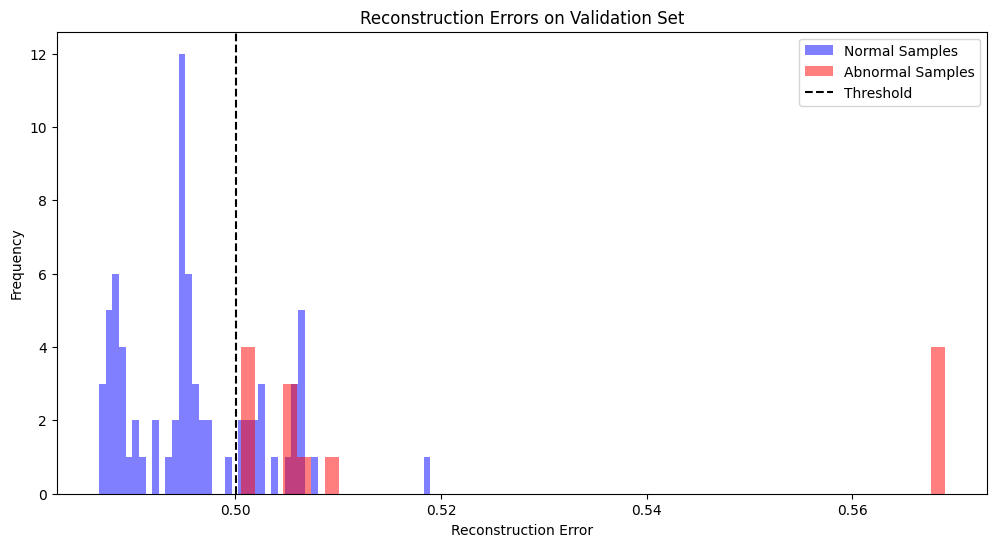

Best Threshold = 0.503017, Best F1 Score = 0.7925
Evaluation on Test Set:
Accuracy = 0.8735632183908046
Precision = 0.7
Recall = 0.9130434782608695
F1 Score = 0.7924528301886793
Confusion Matrix:
 [[55  9]
 [ 2 21]]
Fold 5
Epoch 1/15, Loss: 1.138338
Epoch 2/15, Loss: 0.794791
Epoch 3/15, Loss: 0.558331
Epoch 4/15, Loss: 0.528670
Epoch 5/15, Loss: 0.524752
Epoch 6/15, Loss: 0.523873
Epoch 7/15, Loss: 0.523219
Epoch 8/15, Loss: 0.522695
Epoch 9/15, Loss: 0.522392
Epoch 10/15, Loss: 0.521862
Epoch 11/15, Loss: 0.521504
Epoch 12/15, Loss: 0.521255
Epoch 13/15, Loss: 0.521095
Epoch 14/15, Loss: 0.521027
Epoch 15/15, Loss: 0.520652
Best threshold: 0.5051440066761441, Best F1 Score: 0.7234042553191489


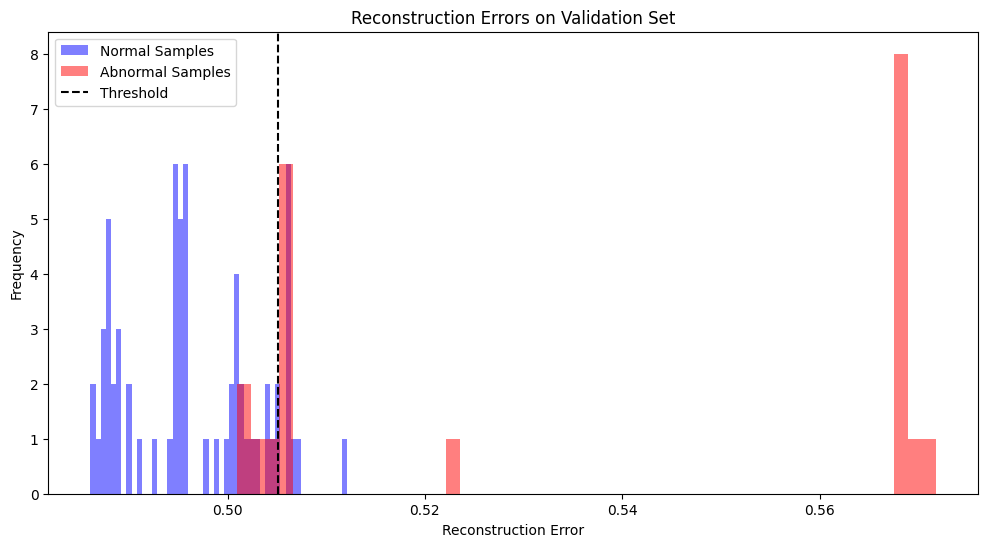

Best Threshold = 0.510030, Best F1 Score = 0.6957
Evaluation on Test Set:
Accuracy = 0.9195402298850575
Precision = 1.0
Recall = 0.5333333333333333
F1 Score = 0.6956521739130436
Confusion Matrix:
 [[72  0]
 [ 7  8]]


In [13]:
acc = []
prec = []
rec = []
f1 = []
for fold, (train_idx, val_idx) in enumerate(skf.split(features_original, label)):
    
    print(f"Fold {fold + 1}")
    
   # Get full fold data
    fold_data, fold_labels = features_original[train_idx], label[train_idx]
    val_data, val_labels = features_original[val_idx], label[val_idx]
   
    # Split into training and validation folds
    X_train, X_temp, y_train, y_temp = train_test_split(fold_data, fold_labels, test_size=0.2, shuffle=True, random_state=np.random.randint(0, 1000))
    X_val, X_test, y_val, y_test = train_test_split(val_data, val_labels, test_size=0.5, shuffle=True, random_state=np.random.randint(0, 1000))


    # Train autoencoder on the training fold
    model = train_autoencoder(features_normal, epochs=15, batch_size=64)

    # Add channel dimension to X_val
    X_val = X_val[:, np.newaxis, :]

    # Evaluate on validation fold
    val_normal = X_val[y_val == 0]
    val_abnormal = X_val[y_val == 1]
    val_errors_normal = compute_reconstruction_loss(model, val_normal)
    val_errors_abnormal = compute_reconstruction_loss(model, val_abnormal)
    val_errors = np.concatenate([val_errors_normal, val_errors_abnormal])
    y_val_combined = np.concatenate([np.zeros(len(val_errors_normal)), np.ones(len(val_errors_abnormal))])
    
    threshold, best_f1 = find_best_threshold(val_errors, y_val_combined)
    print(f"Best threshold: {threshold}, Best F1 Score: {best_f1}")

    # Plot histogram of reconstruction errors on both normal and abnormal samples
    plt.figure(figsize=(12, 6))
    plt.hist(val_errors_normal, bins=50, alpha=0.5, label='Normal Samples', color='blue')
    plt.hist(val_errors_abnormal, bins=50, alpha=0.5, label='Abnormal Samples', color='red')
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
    plt.title('Reconstruction Errors on Validation Set')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    
    X_test = X_test[:, np.newaxis, :]  # Add channel dimension    
    val_errors_test = compute_reconstruction_loss(model, X_test)
    # Evaluate on test set
    evaluate_on_test_with_threshold_search(model, X_test, y_test)
    acc.append(accuracy_score(y_test, (val_errors_test > threshold).astype(int)))
    prec.append(precision_score(y_test, (val_errors_test > threshold).astype(int)))
    rec.append(recall_score(y_test, (val_errors_test > threshold).astype(int)))
    f1.append(f1_score(y_test, (val_errors_test > threshold).astype(int)))



In [14]:
np.mean(acc), np.mean(prec), np.mean(rec), np.mean(f1)

(0.7824712643678161,
 0.5970146845654503,
 0.7139473684210527,
 0.5870813397129186)

# Observation:


Average score:

Accuracy = 0.7824712643678161

Precision = 0.5970146845654503

Recall = 0.7139473684210527

F1 Score = 0.5870813397129186


Best:

Accuracy = 0.8735632183908046

Precision = 0.7

Recall = 0.9130434782608695

F1 Score = 0.7924528301886793

Confusion Matrix:

 [[55  9]

 [ 2 21]]
